# Content-Based Recommendation System

Create a content-based recommendation system using cosine similarity on feature matrices.

In [1]:
# Standard data science libraries
import pandas as pd
import numpy as np
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# Other libraries
import time
import pickle
import re
from PIL import Image
# sklearn packages
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

In [2]:
with open('df_w_features.pickle', 'rb') as f:
    df= pickle.load(f)

In [3]:
df.reset_index(inplace=True, drop=True)

In [4]:
df = df.drop(columns='index')

In [5]:
df.head()

name              brand      price  \
0  Tote  Victoria's Secret  $21.99$74   
1  Tote         Anne Klein  $17.99$69   
2  Tote          Unbranded  $16.99$60   
3  Tote          Unbranded  $15.99$60   
4  Tote  Victoria's Secret  $25.99$68   

                                             bag_url       img_filename  \
0  https://www.thredup.com/product/handbags-victo...  thredup_vic_0.png   
1  https://www.thredup.com/product/handbags-anne-...  thredup_ann_1.png   
2  https://www.thredup.com/product/handbags-unbra...  thredup_unb_2.png   
3  https://www.thredup.com/product/handbags-unbra...  thredup_unb_3.png   
4  https://www.thredup.com/product/handbags-victo...  thredup_vic_4.png   

   label  is_ethical   source  cleaned_price  \
0  totes           1  thredup          21.99   
1  totes           1  thredup          17.99   
2  totes           1  thredup          16.99   
3  totes           1  thredup          15.99   
4  totes           1  thredup          25.99   

                                      feature_matrix  
0  [[0.0, 34.082092, 120.07053, 34.426167, 60.972...  
1  [[0.0, 59.236874, 93.56827, 3.9990442, 0.0, 25...  
2  [[0.0, 62.95456, 4.9559455, 45.43826, 0.0, 143...  
3  [[0.0, 32.848614, 31.133387, 28.699326, 4.2855...  
4  [[0.0, 55.67337, 91.1055, 17.396587, 8.476363,...

#### Create master feature matrix

The master feature matrix needs to be a matrix with rows = each observation and each column = a single point of its image vector. Resulting matrix shape should be $number of observations$  x  1024.


In [6]:
feature_matrix = np.reshape(np.matrix(df['feature_matrix']), (-1,1))

In [7]:
df_feature_matrix = pd.DataFrame(df['feature_matrix'])

In [8]:
df_feature_matrix.head()

feature_matrix
0  [[0.0, 34.082092, 120.07053, 34.426167, 60.972...
1  [[0.0, 59.236874, 93.56827, 3.9990442, 0.0, 25...
2  [[0.0, 62.95456, 4.9559455, 45.43826, 0.0, 143...
3  [[0.0, 32.848614, 31.133387, 28.699326, 4.2855...
4  [[0.0, 55.67337, 91.1055, 17.396587, 8.476363,...

In [232]:
# df_feature_matrix.rename({0: 'feature_matrix'}, axis=1, inplace=True)

In [9]:
# function to turn each feature_matrix into a single array
def matrix_to_array(row):
    return np.array(row.feature_matrix[0])

In [11]:
# apply the above function to the feature_matrix column and create a new column called feature_list
df_feature_matrix['feature_list'] = df_feature_matrix.apply(matrix_to_array, axis=1)

In [12]:
df_feature_matrix.head()

feature_matrix  \
0  [[0.0, 34.082092, 120.07053, 34.426167, 60.972...   
1  [[0.0, 59.236874, 93.56827, 3.9990442, 0.0, 25...   
2  [[0.0, 62.95456, 4.9559455, 45.43826, 0.0, 143...   
3  [[0.0, 32.848614, 31.133387, 28.699326, 4.2855...   
4  [[0.0, 55.67337, 91.1055, 17.396587, 8.476363,...   

                                        feature_list  
0  [0.0, 34.082092, 120.07053, 34.426167, 60.9722...  
1  [0.0, 59.236874, 93.56827, 3.9990442, 0.0, 25....  
2  [0.0, 62.95456, 4.9559455, 45.43826, 0.0, 143....  
3  [0.0, 32.848614, 31.133387, 28.699326, 4.28552...  
4  [0.0, 55.67337, 91.1055, 17.396587, 8.476363, ...

In [13]:
# create a master matrix containing all feature matrices

# instatiate an zeros matrix in the shape of the desired result
feature_matrix = np.zeros((6094,1024))

# iterate through each row in the feature_list series, and then each item within each row to add to zeros matrix
for i, row in df_feature_matrix.iterrows():
    for idx, num in enumerate(row['feature_list']):
        feature_matrix[i][idx] += num

In [14]:
# check the shape of the matrix to make sure it matches with (6094,1024)
feature_matrix.shape

(6094, 1024)

#### Create similarity matrices

Using the master `feature_matrix` from above, we can now build out similarity matrices using two different types of similarity measures - cosine similarity and linear kernel.

In [15]:
# create cosine similarity matrices; two types of similarity matrices to compare results
lin_kernel = linear_kernel(feature_matrix, feature_matrix)
cosine_sim = cosine_similarity(feature_matrix, feature_matrix)

# construct a reverse map of filenames and movie titles
indices = pd.Series(df.index, index=df['img_filename']).drop_duplicates()

In [66]:
# check shape of the similarity matrix - should be (6094, 6094)
print(cosine_sim.shape)
print(lin_kernel.shape)

(6094, 6094)
(6094, 6094)


#### Create functions to return similar bag images

Build two functions:
1. <i>Overall results.</i> Function to return overall most similar bag images for a given input bag image - we expect the results of this function to return more similar images; we'll use the results of this function to determine which similarity measure to use.
2. <i>Ethical results.</i> Function to return similar ethical bag images - we expect the results of this function to return less similar images since we're adding an additional condition to the results.

Overall results: 

In [89]:
def display_recommendations(filename, similarity_matrix):
    '''
    Function to return the overall top 10 most similar bag images for a given file
    INPUTS:
    ------
    filename: str value of image filename
    similarity_matrix: np.array() value of similarity matrix
    
    OUTPUT:
    -------
    Displays filename, similarity score, and image of the input file and resulting top 10 most similar bags
    '''
    # Get filepath of input filename
    input_label = re.findall('(totes|backpacks|shoulder_bags|clutches|fanny_packs|weekenders|bucket_bags|circles)' ,str(df[df['img_filename']==filename]['label']))[0]
    input_filepath = f'./data_original/{input_label}/{filename}'
    
    # Get the index of the bag that matches the filename
    idx = indices[filename]

    # Get the pairwise similarity scores of all bags with input bag
    sim_scores = list(enumerate(similarity_matrix[idx]))

    # Sort the filenames based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 12 most similar bags
    sim_scores = sim_scores[0:13]

    # Get the bag indices
    img_indices = [i[0] for i in sim_scores]

    # Get the top 10 most similar bag filenames
    top_results = df['img_filename'].iloc[img_indices]
    
    # Display input image details
    print('INPUT IMAGE:')
    print('------------')
    print(filename)
    input_image = Image.open(input_filepath)
    display(input_image.resize((250, 250), Image.ANTIALIAS))
    
    # Display top 10 most similar bags w/ details
    print('MOST SIMILAR IMAGES:')
    print('--------------------')
    for i, result in enumerate(list(top_results)):
        print(result)
        print(sim_scores[i])
        output_label = re.findall('(totes|backpacks|shoulder_bags|clutches|fanny_packs|weekenders|bucket_bags|circles)' ,str(df[df['img_filename']==result]['label']))[0]
        output_image = Image.open(f'./data_original/{output_label}/{result}')
        display(output_image.resize((250, 250), Image.ANTIALIAS))

INPUT IMAGE:
------------
mango_99.png


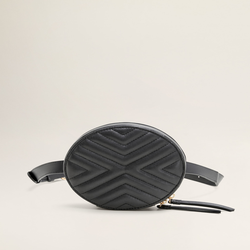

MOST SIMILAR IMAGES:
--------------------
mango_99.png
(3100, 1.0000000000000013)


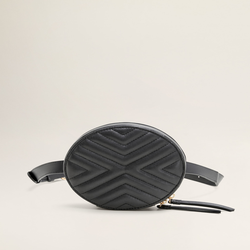

mango_94.png
(3095, 0.85390173216921)


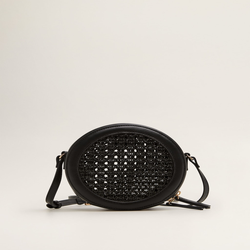

omybag__90.png
(6004, 0.8338423048493854)


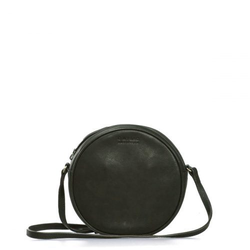

thredup_vic_1035.png
(863, 0.8107769591026177)


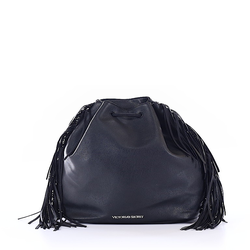

thredup_son_1506.png
(1398, 0.797136485633173)


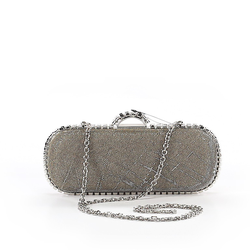

stella_19.jpg
(2830, 0.7924284193399239)


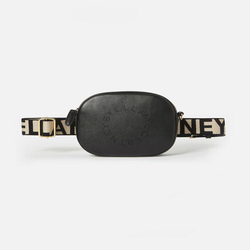

thredup_adr_1171.png
(999, 0.7910692733630442)


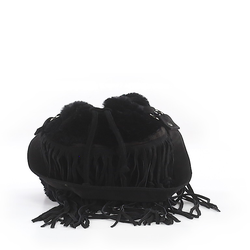

za_80.jpg
(3532, 0.7851150594995336)


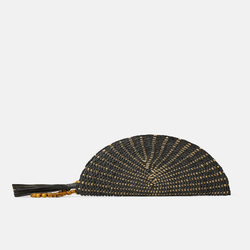

thredup_ban_1284.png
(1176, 0.7822951912788354)


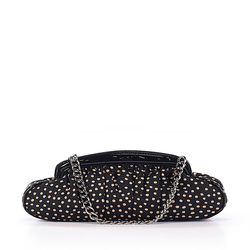

thredup_unb_1213.png
(1105, 0.7782655104239771)


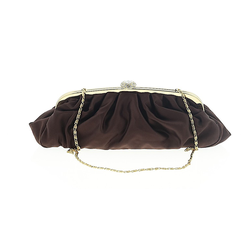

mango_97.png
(3098, 0.7746882712197595)


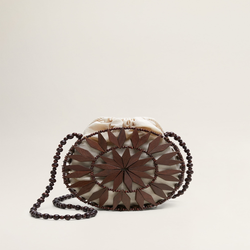

omybag__88.png
(6002, 0.7739918850816583)


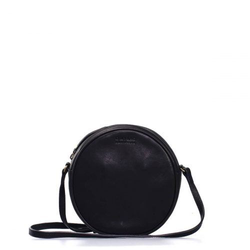

mango_124.png
(3125, 0.7730467942902851)


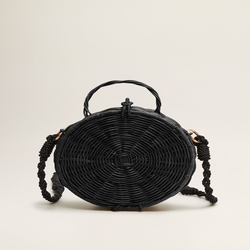

In [90]:
display_recommendations('mango_99.png', cosine_sim)

INPUT IMAGE:
------------
thredup_bra_13.png


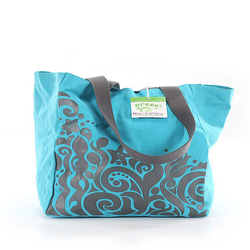

MOST SIMILAR IMAGES:
--------------------
thredup_bra_13.png
(13, 1.0000000000000013)


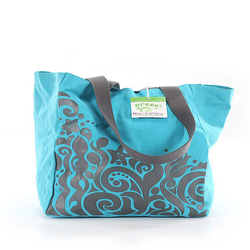

thredup_bra_6.png
(6, 0.833880609870583)


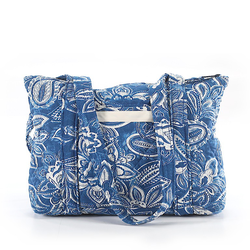

thredup_unb_398.png
(398, 0.8223965001842832)


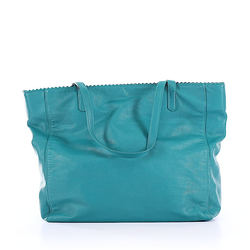

thredup_unb_401.png
(405, 0.8191092373186278)


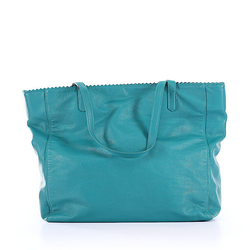

thredup_don_489.png
(493, 0.806316192631173)


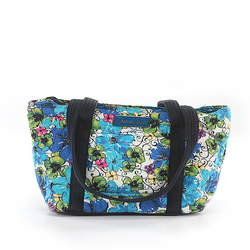

thredup_mud_541.png
(545, 0.8055089763326965)


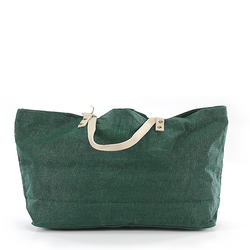

thredup_unb_2366.png
(1825, 0.8031551321127623)


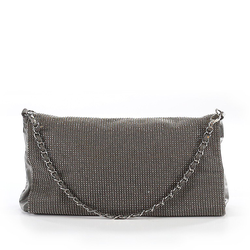

thredup_bra_580.png
(584, 0.7985542011935837)


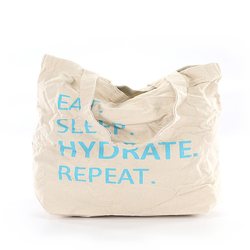

thredup_for_2708.png
(2124, 0.7980433685472055)


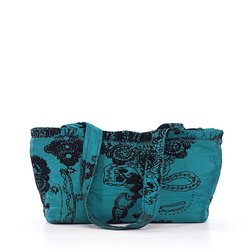

thredup_vic_75.png
(75, 0.7963045227797902)


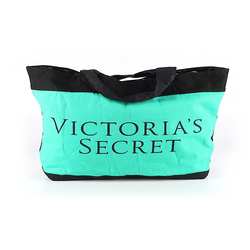

In [271]:
display_recommendations('thredup_bra_13.png', cosine_sim)

INPUT IMAGE:
------------
thredup_bra_13.png


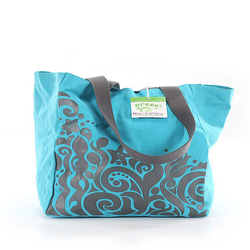

MOST SIMILAR IMAGES:
--------------------
thredup_vic_14.png
(14, 1198739.365854008)


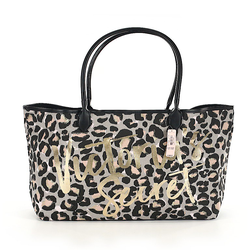

omybag__51.png
(5965, 1182727.896059358)


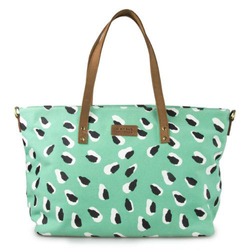

th_1.jpg
(2936, 1105771.5355621662)


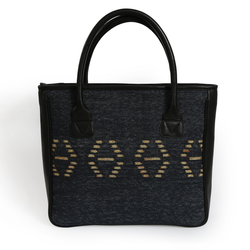

thredup_unb_688.png
(692, 1038701.3941163186)


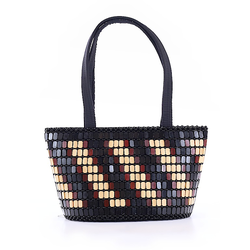

thredup_unb_79.png
(79, 1036854.0966539036)


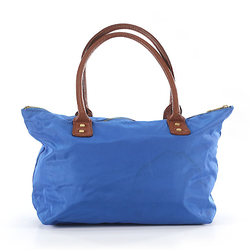

th_2.jpg
(2937, 988922.7654887727)


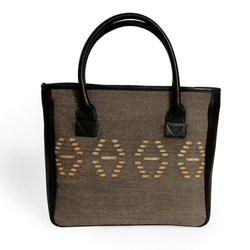

In [248]:
display_recommendations('thredup_bra_13.png', lin_kernel)

INPUT IMAGE:
------------
nordstrom_54.png


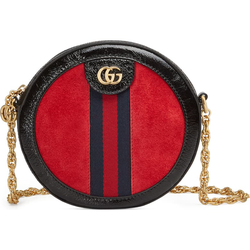

MOST SIMILAR IMAGES:
--------------------
nordstrom_54.png
(5895, 1.0000000000000007)


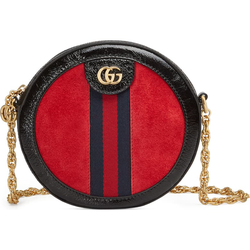

nordstrom_67.png
(5908, 0.8219909479212212)


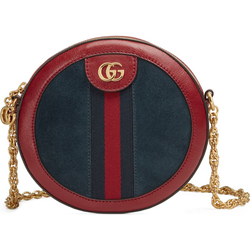

nordstrom_55.png
(5896, 0.8153987797901321)


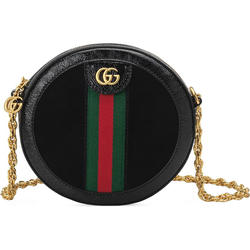

thredup_unb_285.png
(285, 0.7761623064883139)


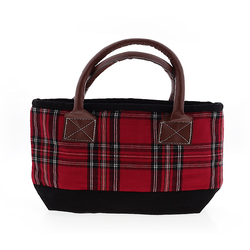

za_301.jpg
(3748, 0.7723407557900002)


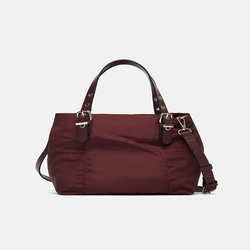

thredup_bra_1990.png
(1467, 0.7701038487148288)


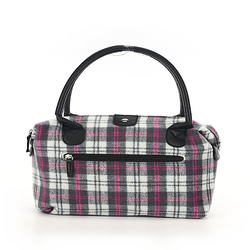

thredup_unb_334.png
(334, 0.7700641686240789)


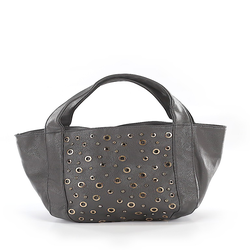

thredup_nin_2165.png
(1641, 0.7693673244825112)


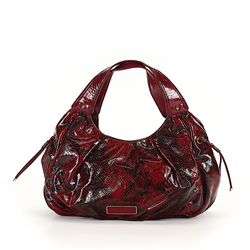

thredup_pri_192.png
(192, 0.7630237556261861)


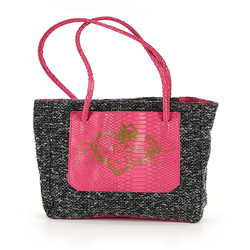

herschel_t_49.png
(5509, 0.7616788577548028)


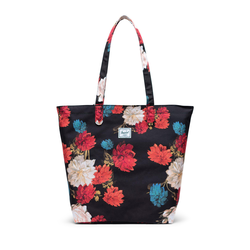

In [272]:
display_recommendations('nordstrom_54.png', cosine_sim)

INPUT IMAGE:
------------
nordstrom_54.png


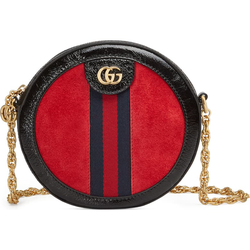

MOST SIMILAR IMAGES:
--------------------
nordstrom_60.png
(5901, 1586676.4569057042)


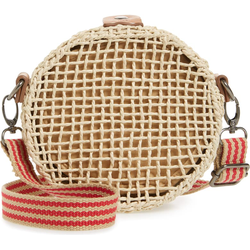

thredup_unb_285.png
(285, 1543448.0852267018)


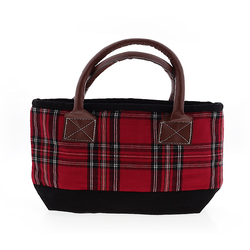

nordstrom_55.png
(5896, 1505308.4409116192)


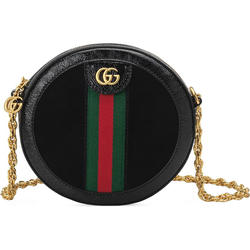

nordstrom_33.png
(5874, 1496855.7463129165)


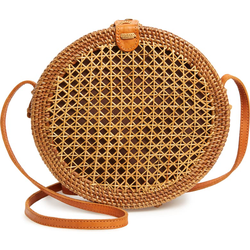

nordstrom_67.png
(5908, 1494740.7444585005)


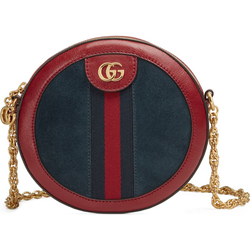

thredup_ann_2274.png
(1749, 1494587.0939248314)


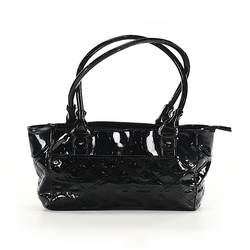

In [250]:
display_recommendations('nordstrom_54.png', lin_kernel)

INPUT IMAGE:
------------
za_257.jpg


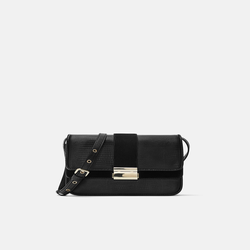

MOST SIMILAR IMAGES:
--------------------
za_257.jpg
(3704, 1.0000000000000002)


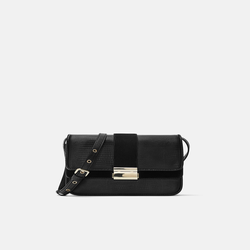

za_195.jpg
(3647, 0.9340332840720595)


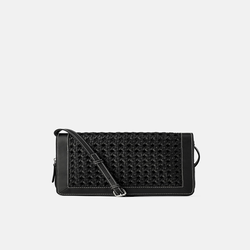

top_200.png
(3349, 0.9314804673705128)


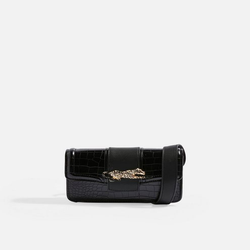

za_68.jpg
(3520, 0.9312099938748425)


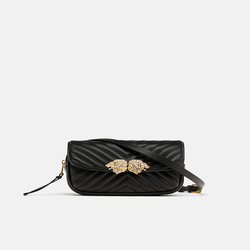

thredup_jud_1507.png
(1399, 0.9301847332708325)


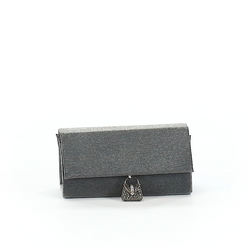

za_272.jpg
(3719, 0.9267611851401252)


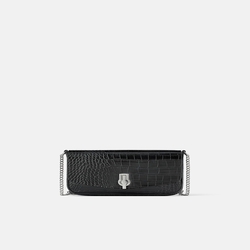

mango_72.png
(3073, 0.913331597102066)


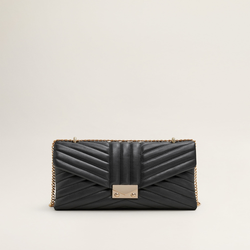

za_255.jpg
(3702, 0.908261771966732)


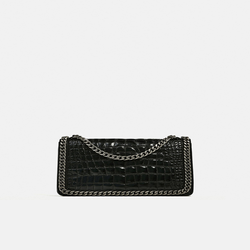

za_149.jpg
(3601, 0.9073456168206334)


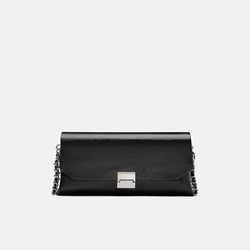

za_259.jpg
(3706, 0.9064982588319049)


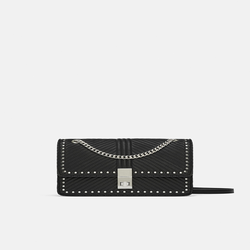

In [273]:
display_recommendations('za_257.jpg', cosine_sim)

INPUT IMAGE:
------------
za_257.jpg


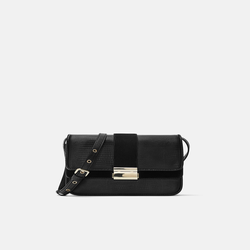

MOST SIMILAR IMAGES:
--------------------
herschel_202.png
(3977, 564419.8750436279)


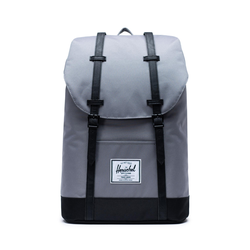

herschel_360.png
(4135, 536680.4852249192)


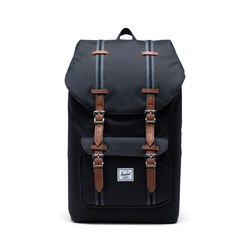

thredup_ann_2274.png
(1749, 532918.6627380425)


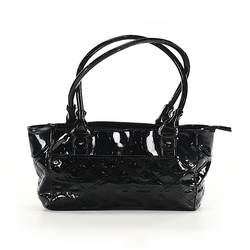

herschel_203.png
(3978, 531300.3066538229)


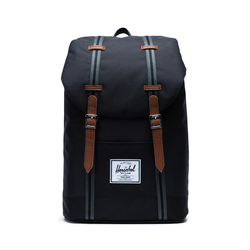

herschel_192.png
(3967, 528690.5837463599)


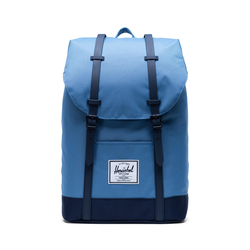

herschel_201.png
(3976, 524314.921432783)


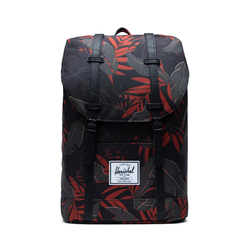

In [243]:
display_recommendations('za_257.jpg', lin_kernel)

INPUT IMAGE:
------------
ia_48.png


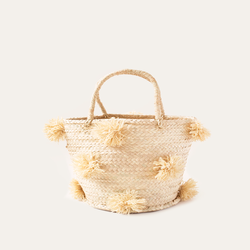

MOST SIMILAR IMAGES:
--------------------
ia_48.png
(2408, 1.0000000000000009)


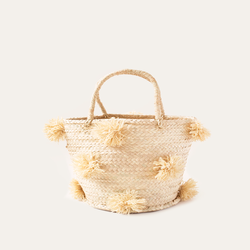

ia_39.png
(2399, 0.8960223128300149)


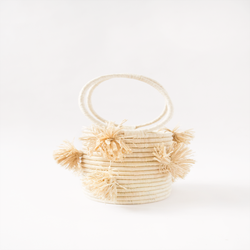

ia_33.png
(2393, 0.8771353304210316)


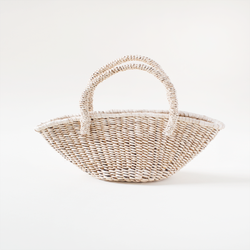

ia_38.png
(2398, 0.8721113770782318)


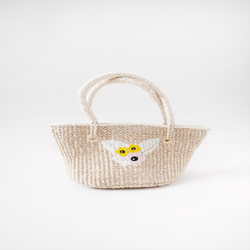

thredup_men_1138.png
(966, 0.8609770820781928)


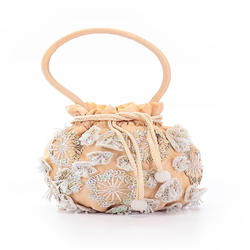

av_35.png
(2625, 0.8462882591496399)


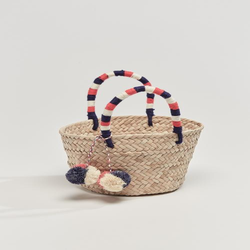

thredup_coc_1146.png
(974, 0.8352206176953143)


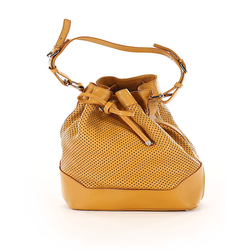

hm_8.png
(3431, 0.8342112899290488)


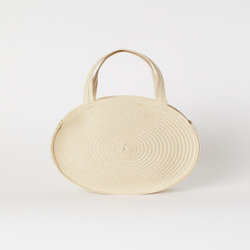

top_64.png
(3214, 0.8323356103080846)


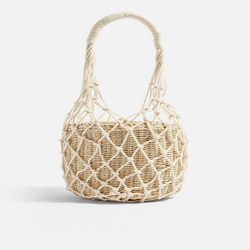

mango_63.png
(3064, 0.830025124006825)


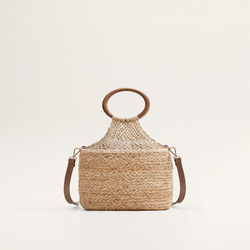

In [274]:
display_recommendations('ia_48.png', cosine_sim)

INPUT IMAGE:
------------
za_2.jpg


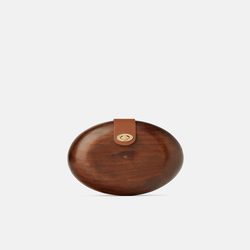

MOST SIMILAR IMAGES:
--------------------
za_2.jpg
(3454, 1.0000000000000007)


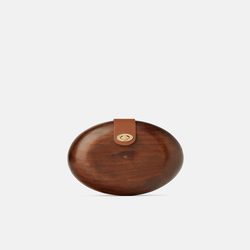

za_3.jpg
(3455, 1.0000000000000007)


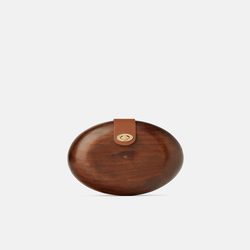

omybag__91.png
(6005, 0.9296288722811029)


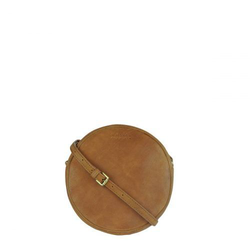

mango_90.png
(3091, 0.9113371945527805)


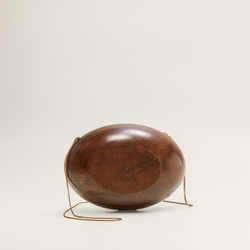

omybag__89.png
(6003, 0.8907843057587331)


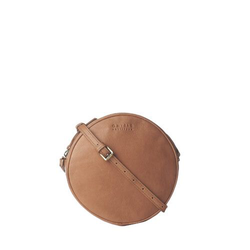

omybag__87.png
(6001, 0.8648362339046057)


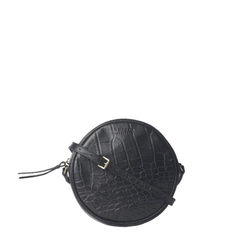

herschel_1181.png
(4956, 0.817535978805796)


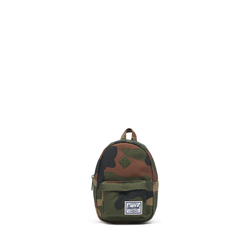

mango_83.png
(3084, 0.8093565984584344)


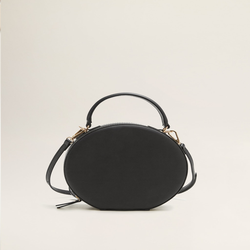

whimsy_row__5.png
(6085, 0.7907194060617334)


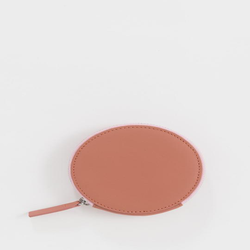

rains__37.jpg
(6069, 0.7893985207842358)


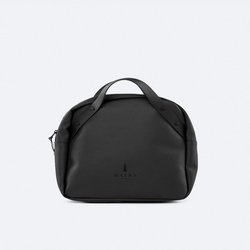

In [275]:
display_recommendations('za_2.jpg', cosine_sim)

Ethical results:

In [91]:
def display_ethical_recommendations(filename, similarity_matrix):
    '''
    Function to return the top 12 most similar ETHICAL bag images for a given file
    INPUTS:
    ------
    filename: str value of image filename
    similarity_matrix: np.array() value of similarity matrix
    
    OUTPUT:
    -------
    Displays filename, similarity score, and image of the input file and resulting top 10 most similar ethical bags
    '''
    # Get filepath of input filename
    input_label = re.findall('(totes|backpacks|shoulder_bags|clutches|fanny_packs|weekenders|bucket_bags|circles)' ,str(df[df['img_filename']==filename]['label']))[0]
    input_filepath = f'./data_original/{input_label}/{filename}'
    
    # Get the index of the bag that matches the filename
    idx = indices[filename]

    # Get the pairwise similarity scores of all bags with input bag
    sim_scores = list(enumerate(similarity_matrix[idx]))

    # Sort the filenames based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 100 most similar bags
    sim_scores = sim_scores[0:101]

    # Get the bag indices
    img_indices = [i[0] for i in sim_scores]

    # Get the top 100 most similar bag filenames
    top_results = df['img_filename'].iloc[img_indices]
    
    # Get ethical status for each bag
    ethical_status = df['is_ethical'].iloc[img_indices]
    
    # Zip results of filename and ethical status
    zipped_results = list(zip(img_indices, top_results, ethical_status, sim_scores))
    
    # Filter out unethical results
    top_ethical_results = [x for x in zipped_results if x[2] == 1]
    top_ethical_results = top_ethical_results[:12]
    
    # Display the input image 
    print('INPUT IMAGE:')
    print('------------')
    print(filename)
    input_image = Image.open(input_filepath)
    display(input_image.resize((250, 250), Image.ANTIALIAS))
    print('MOST SIMILAR IMAGES:')
    print('--------------------')
    
    # Display top 12 ethical bags
    for i, result in enumerate(top_ethical_results):
        print(result)
        print(result[3])
        result_filename = result[1]
        output_label = re.findall('(totes|backpacks|shoulder_bags|clutches|fanny_packs|weekenders|bucket_bags|circles)', str(df[df['img_filename']==result[1]]['label']))[0]
        output_image = Image.open(f'./data_original/{output_label}/{result[1]}')
        display(output_image.resize((250, 250), Image.ANTIALIAS))

INPUT IMAGE:
------------
za_2.jpg


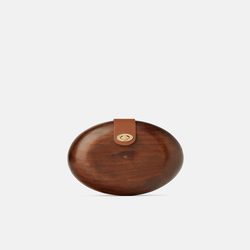

MOST SIMILAR IMAGES:
--------------------
(6005, 'omybag__91.png', 1, (6005, 0.9296288722811029))
(6005, 0.9296288722811029)


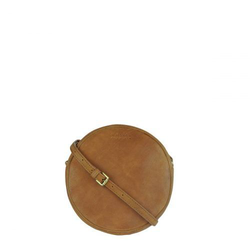

(6003, 'omybag__89.png', 1, (6003, 0.8907843057587331))
(6003, 0.8907843057587331)


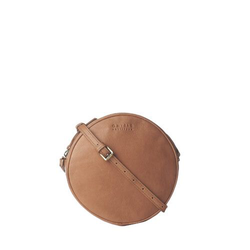

(6001, 'omybag__87.png', 1, (6001, 0.8648362339046057))
(6001, 0.8648362339046057)


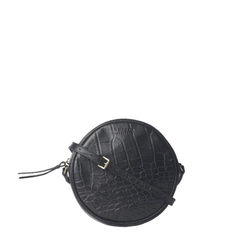

(6085, 'whimsy_row__5.png', 1, (6085, 0.7907194060617334))
(6085, 0.7907194060617334)


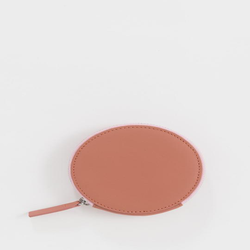

(2772, 'sq_41.jpg', 1, (2772, 0.7888876027261029))
(2772, 0.7888876027261029)


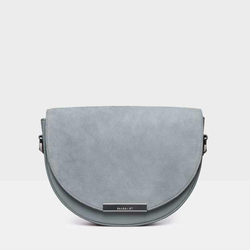

(2595, 'av_5.png', 1, (2595, 0.7804203015886991))
(2595, 0.7804203015886991)


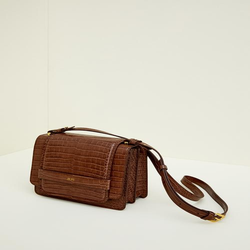

(6084, 'whimsy_row__4.png', 1, (6084, 0.7766619427350745))
(6084, 0.7766619427350745)


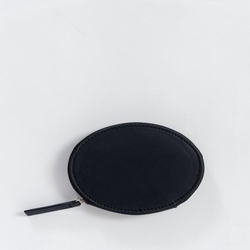

(1178, 'thredup_pra_1286.png', 1, (1178, 0.7688281498085767))
(1178, 0.7688281498085767)


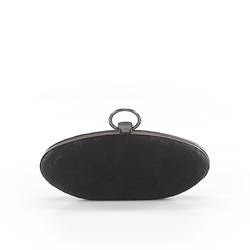

(6002, 'omybag__88.png', 1, (6002, 0.7405403963062717))
(6002, 0.7405403963062717)


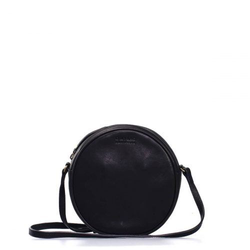

(6004, 'omybag__90.png', 1, (6004, 0.7026466142717077))
(6004, 0.7026466142717077)


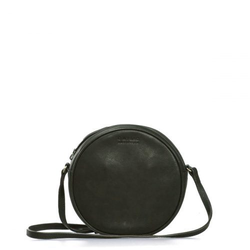

(2830, 'stella_19.jpg', 1, (2830, 0.6860487443291814))
(2830, 0.6860487443291814)


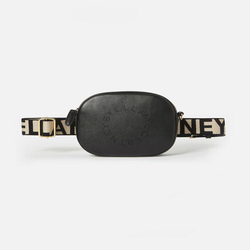

(2689, 'gunas_18.png', 1, (2689, 0.685193403201604))
(2689, 0.685193403201604)


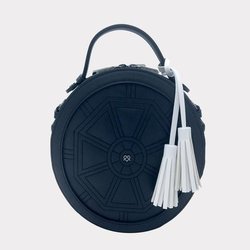

In [92]:
display_ethical_recommendations('za_2.jpg', cosine_sim)

INPUT IMAGE:
------------
za_282.jpg


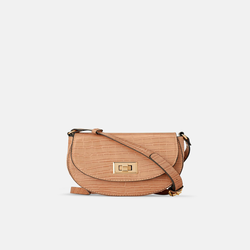

MOST SIMILAR IMAGES:
--------------------
(2254, 'thredup_ban_2839.png', 1, (2254, 0.7979691645896788))
(2254, 0.7979691645896788)


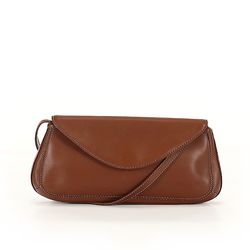

(655, 'thredup_kat_651.png', 1, (655, 0.793734715250538))
(655, 0.793734715250538)


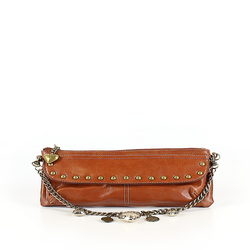

(2028, 'thredup_nin_2606.png', 1, (2028, 0.7855463371042585))
(2028, 0.7855463371042585)


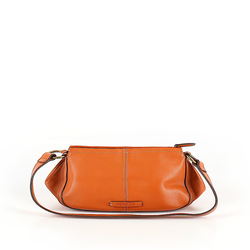

(2898, 'stella_87.jpg', 1, (2898, 0.7822008786164788))
(2898, 0.7822008786164788)


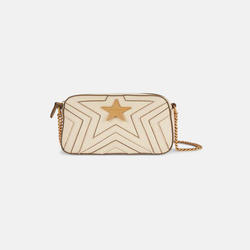

(5994, 'omybag__80.png', 1, (5994, 0.7809586525157758))
(5994, 0.7809586525157758)


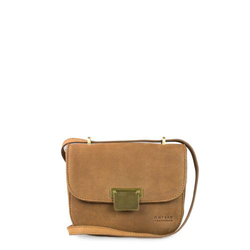

(1303, 'thredup_tra_1411.png', 1, (1303, 0.7797430014112121))
(1303, 0.7797430014112121)


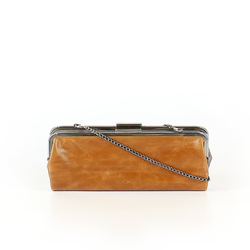

(5986, 'omybag__72.png', 1, (5986, 0.7769207247604059))
(5986, 0.7769207247604059)


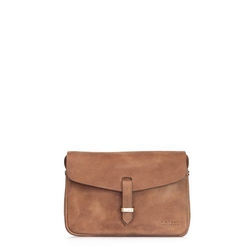

(2551, 'mimco_98.png', 1, (2551, 0.766970689863267))
(2551, 0.766970689863267)


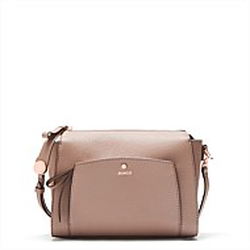

(2594, 'av_4.png', 1, (2594, 0.7590393605822248))
(2594, 0.7590393605822248)


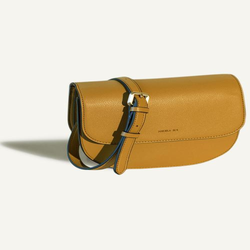

(2787, 'sq_56.jpg', 1, (2787, 0.7508677939481715))
(2787, 0.7508677939481715)


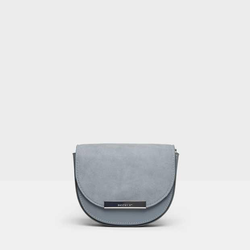

(2599, 'av_9.png', 1, (2599, 0.7459721055369113))
(2599, 0.7459721055369113)


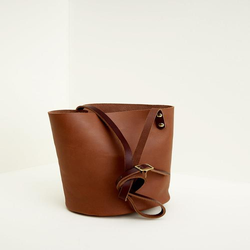

(2611, 'av_21.png', 1, (2611, 0.7392161810371899))
(2611, 0.7392161810371899)


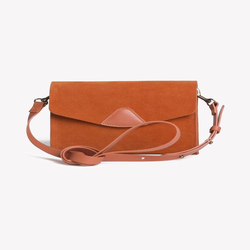

In [88]:
get_ethical_recommendations('za_282.jpg', cosine_sim)